Reproducibility Project *by* Group 102
--------------------------------------------------------------
This is a notebook demonstrating the efforts made for the Reproducibility Project of the 2020-21 edition of CS4240 Deep Learning Course at Delft University of Technology.

Accompanying this notebook is a blog post that can be found [here]().

## Learning to Learn by Gradient Descent by Gradient Descent  [[PDF](https://arxiv.org/pdf/1606.04474v2.pdf)]
The goal of this project is to replicate the results found by Andrychowicz et al.
Furthermore, we provide analyse the performance (time-wise) of the implementation.

### Replication

We first try to replicate the results by adapting the code provided by [chenwydj](https://github.com/chenwydj/learning-to-learn-by-gradient-descent-by-gradient-descent).

First, we set some Jupyter Notebook environment variables.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!mkdir _cache
!mkdir _tracker_cache

A subdirectory or file _cache already exists.
A subdirectory or file _tracker_cache already exists.


We have replicated the results using `python==3.8.7` and `pytorch==1.8.0` on the MNIST dataset.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

import torch.optim as optim

from globals import trackers
from models import MNISTLoss, MNISTNet, MNISTNet2Layer, MNISTNetBig, MNISTRelu
from training import fit_optimizer, get_fit_dict_test, fit_normal
from util import show_and_save_plot, markup_plot, tracker_timings_bar_chart

We train the optimizer network using a learning rate of 0.01 for 50 epochs. We use minibatches of 128 images.
The architecture of the optimizee network consists of a single hidden layer with 20 hidden units with the sigmoid activation function.

In [3]:
BATCH_SIZE=128

In [4]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet,
                                      lr=0.01,
                                      n_epochs=50,
                                      n_tests=20,
                                      out_mul=0.1,
                                      batch_size=BATCH_SIZE,
                                      iterations=20,
                                      preproc=True,
                                      tracker='Training')

We first create the 'normal' optimizers with which we will compare the meta optimizer.

In [5]:
NORMAL_OPTS = [(optim.Adam, {}),
               (optim.RMSprop, {}),
               (optim.SGD, {'momentum': 0.9}),
               (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']
N_TESTS = 100

We also set their initial learning rate, these learning rates were found using a random search.

Then we train the optimizee network using these 'normal' optimizers.

In [6]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    trackers[OPT_NAMES[i]].start_timer('optimize')
    fit_data[:, :, i] = np.array(
        fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, tracker=OPT_NAMES[i],
                   **extra_kwargs))
    trackers[OPT_NAMES[i]].stop_timer('optimize')

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

We also try to train the optimizee network using the 'LSTM' optimizer.

In [7]:
fit_data[:, :, len(OPT_NAMES)] = np.array(
    get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False,
                      tracker='LSTM'))

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

Then plot and saves the results.

c:\development\tudelft\deeplearning\learning-to-learn-by-gradient-descent-by-gradient-descent\venv\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
c:\development\tudelft\deeplearning\learning-to-learn-by-gradient-descent-by-gradient-descent\venv\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


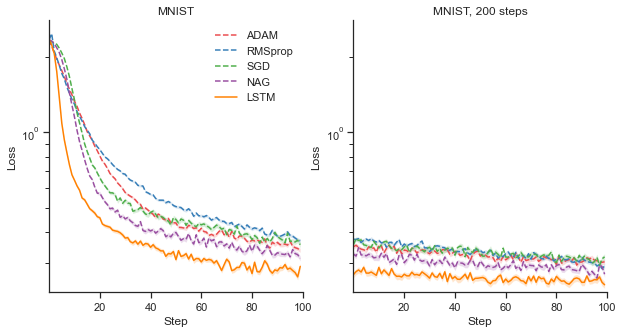

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)

ax1 = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['LSTM'], linestyle='--',
                 color=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'], ax=ax1)

ax2 = sns.tsplot(data=fit_data[:, 100:, :], condition=OPT_NAMES + ['LSTM'], linestyle='--',
                 color=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'], ax=ax2)

markup_plot(ax1, 'MNIST', domain=range(20, 101, 20))
markup_plot(ax2, 'MNIST, 200 steps', domain=range(20, 101, 20), leg=False, ylim=ax1.get_ylim())

show_and_save_plot('MNIST', path='MNIST', markup=False)

We see that this is similar to the results produced by the paper:
![](images/p_MNIST.png)

Also replicate the generalizations found within the paper.
We first look at the generalization to multiple layers.

In [9]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(
        fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200,
                   **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(
    get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False,
                      tracker='LSTM2Layer'))

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

c:\development\tudelft\deeplearning\learning-to-learn-by-gradient-descent-by-gradient-descent\venv\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


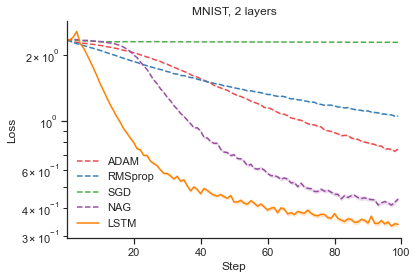

In [10]:
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['LSTM'], linestyle='--',
                color=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'])

show_and_save_plot('MNIST, 2 layers', ax=ax, path='MNIST_2_layer', domain=range(20, 101, 20))

We once again find similar results
![](images/p_MNIST_layer.png)

Secondly, we first look at the generalization to more hidden units.

In [11]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(
        fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200,
                   **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(
    get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False,
                      tracker='LSTMBig'))

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

c:\development\tudelft\deeplearning\learning-to-learn-by-gradient-descent-by-gradient-descent\venv\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


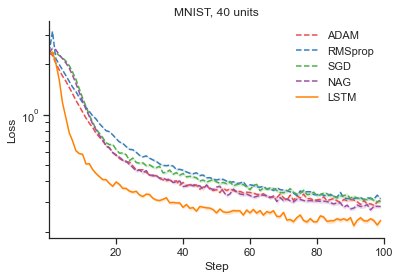

In [12]:
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['LSTM'], linestyle='--',
                color=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'])
show_and_save_plot('MNIST, 40 units', ax=ax, path='MNIST_40_units', domain=range(20, 101, 20))

We once again find similar results
![](images/p_MNIST_40.png)

Secondly, we first look at the generalization to another activation function such as ReLU.

In [13]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(
        fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200,
                   **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(
    get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False,
                      tracker='LSTMRelu'))

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

c:\development\tudelft\deeplearning\learning-to-learn-by-gradient-descent-by-gradient-descent\venv\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


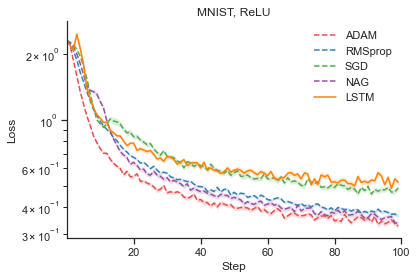

In [14]:
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['LSTM'], linestyle='--',
                color=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'])
show_and_save_plot('MNIST, ReLU', ax=ax, path='MNIST_relu', domain=range(20, 101, 20))

We find that LSTM performs worse, however, interestingly enough it performs a lot better than in the paper.
![](images/p_MNIST_Relu.png)


We also cache the trackers

In [32]:
for t in trackers.values():
    t.save()

### Performance Benchmark

After running the code, we benchmark the results, we have tracked the total time spent training during several steps of the
algorithm (Note that this may not work correctly if the notebook isn't run sequentially)

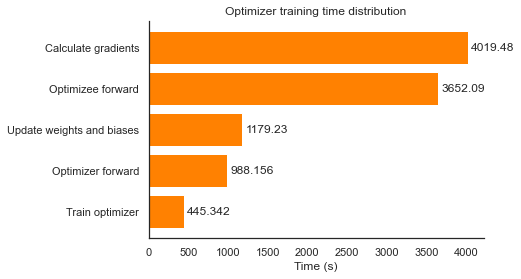

In [28]:
tracker_timings_bar_chart([trackers['Training']],
          select=[('calculate_gradients', 'Calculate gradients'),
                  ('update_hidden_states', 'Update weights and biases'),
                  ('train_optimizer', 'Train optimizer'),
                  ('optimizee_predict', 'Optimizee forward'),
                  ('optimizer_predict', 'Optimizer forward'),],
          title='Optimizer training time distribution',
          colors=['#ff8101']
          )

We observe that most of the time during training is spent by forwards and backwards passes through the MNIST network.
This is due to the algorithm needing to train the optimizee network to find the actual loss of the optimizer network.

We also benchmark the optimizers after running the

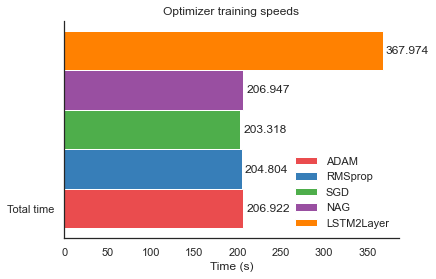

In [29]:
tracker_timings_bar_chart([trackers['ADAM'],
                           trackers['RMSprop'],
                           trackers['SGD'],
                           trackers['NAG'],
                           trackers['LSTM'],],
          select=[('optimize', 'Total time'),],
          title='Optimizer training speeds',
          legend=True,
          colors=['#ea4c4e', '#377eb8', '#4eae4b', '#994fa1', '#ff8101'])

### Speedup Improvements

To improve the speed, we try to increase the batch size of the network and compare the resulting optimizer.
So we first train an optimizer using half the number of iterations but minibatches of 256 samples

In [63]:
large_loss, large_optimizer = fit_optimizer(MNISTLoss, MNISTNet,
                                      lr=0.01,
                                      n_epochs=50,
                                      n_tests=20,
                                      out_mul=0.1,
                                      batch_size=256,
                                      iterations=10,
                                      preproc=True,
                                      tracker='TrainingBatch')

We then use the newly trained optimizer and the old optimizer to train the MNIST network.

In [42]:
compare_data = np.zeros((N_TESTS, 200, 2))

compare_data[:, :, 0] = np.array(
    get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False))


compare_data[:, :, 1] = np.array(
    get_fit_dict_test(N_TESTS, large_optimizer, None, MNISTLoss, MNISTNet, 1, 200, out_mul=0.1,
                      batch_size=BATCH_SIZE,
                      should_train=False))

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

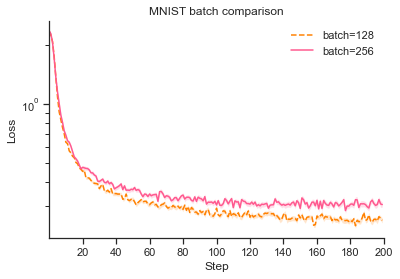

In [53]:
ax = sns.tsplot(data=compare_data[:, :, :], condition=['batch=128', 'batch=256'], linestyle='--',
                color=['#ff8101', '#ff598f'])
show_and_save_plot('MNIST batch comparison', ax=ax, path='MNIST_2_layer', domain=range(20, 201, 20))

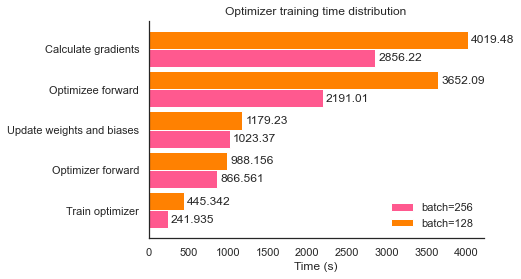

In [62]:
tracker_timings_bar_chart([trackers['TrainingBatch'], trackers['Training']],
                          select=[('calculate_gradients', 'Calculate gradients'),
                                  ('update_hidden_states', 'Update weights and biases'),
                                  ('train_optimizer', 'Train optimizer'),
                                  ('optimizee_predict', 'Optimizee forward'),
                                  ('optimizer_predict', 'Optimizer forward'),],
                          title='Optimizer training time distribution',
                          colors=['#ff598f', '#ff8101'],
                          width=0.45,
                          names=['batch=256', 'batch=128'],
                          legend=True)